In [420]:
from dwave.system import LeapHybridSampler
sampler=LeapHybridSampler(token='DEV-3fc4e66bf879e3fb40a1d09e8be0a7654e806d3c')
from scipy.optimize import linear_sum_assignment
from dwave.system import LeapHybridDQMSampler
import dimod
import numpy as np

# BALANCED ASSIGNMENT PROBLEM AS BQM

Given n agents, n tasks and the efficiency measure of each $i^{th}$ agent to do the $j^{th}$ task. Each task should be alloted to only one agent. Each agent should work on only one task. The objective is to maximise the overall efficiency.  

The cost function $H_c$ for this problem statement is given as:

$$H_c=_{min}\left(-\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{n}w_{i,j}x_{i,j}+\gamma\left(\sum\limits_{i=1}^{n}\left(\sum\limits_{j=1}^{n}x_{i,j}-1\right)^2+\sum\limits_{j=1}^{n}\left(\sum\limits_{i=1}^{n}x_{i,j}-1\right)^2\right)\right)$$
where $\gamma$ is the Lagrange multiplier whose value is usually selected by hit and trial and is initilized to a large value at the beginning. Here, $w_{i,j}$ is the efficiency measure or the edge weight between each agent and each task. The binary variables $x_{i,j}$ is 1 if the $i^{th}$ agent is alloted to the $j^{th}$ task.   

In [427]:
#Get the input on the number of agents from the user in num_agents

response=input('\nThis is a balanced assignment problem.Enter number of agents >')
try:
    num_agents=int(response)
except ValueError: 
    print('Must be an integer.')
    num_agents=int(input('\nEnter number of agents >'))

#For balanced problem, number of agents is equal to the number of tasks
num_tasks=num_agents

# Balanced assignment function

def bal_assignment(num_agents,num_tasks,lagrange,W):
    """Construct BQM for the balanced assignment problem
    Args:
        num_agents (int):
            Number of agents 
        num_tasks (int):
            Number of tasks
        lagrange (float):
            Value of Lagrange multiplier
        W (2-D arr):
            Efficiency Matrix of size (num_agents,num_tasks)
    Returns:
        Binary quadratic model instance
    """
    
    bqm=dimod.AdjVectorBQM(dimod.Vartype.BINARY)
    
    #Add the linear terms in the Hamiltonian xij-xij 
    for agent in range(num_agents):
        for task in range(num_tasks):
            bqm.set_linear('x'+str(agent)+str(task),-2*lagrange-W[agent,task])
            
    #Add the quadratic terms in the Hamiltonian xij-xkj
        
    for task in range(num_tasks):
        for agent1 in range(num_agents):
            for agent2 in range(agent1+1,num_agents):
                key=('x'+str(agent1)+str(task),'x'+str(agent2)+str(task))
                bqm.quadratic[key]=2*lagrange
    
    #Add the quadratic terms in the Hamiltonian xij-xik
    for agent in range(num_agents):
        for task1 in range(num_tasks):
            for task2 in range(task1+1,num_tasks):
                key=('x'+str(agent)+str(task1),'x'+str(agent)+str(task2))
                bqm.quadratic[key]=2*lagrange  
    
    #Don't forget to add the offset which is simply lagrange*(num_agents+num_tasks)
    bqm.add_offset(lagrange*(num_agents+num_tasks))
    return bqm


This is a balanced assignment problem.Enter number of agents >5


## HUNGARIAN METHOD

The Hungarian method is a classical combinatorial optimization algorithm that solves the assignment problem in polynomial time. Now, we randomly generate the efficiency matrix $W$. We are measuring efficiency between 0 to 1. 1 means 100% efficiency and 0 means 0% efficiency. We will use the Hungarian method now to give us the solution to the assignment problem which we will later use to compare with the Hybrid Solver Science Model on Leap. 

In [428]:
#Generate the efficiency matrix 
W=np.random.rand(num_agents,num_agents)

#Find the classical Hungarian solution for the problem
row_id,col_id=linear_sum_assignment(-W)
sol_matrix=np.zeros((num_agents,num_tasks))

#Draw the solution
for k in range(len(row_id)):
    sol_matrix[row_id[k],col_id[k]]=1
print(sol_matrix)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


We can see in the above classical solution that both the constraints are completely satisfied. In the following section, we will look at the solutions using the LeapHybridSampler. We vary the Lagrange multiplier $\gamma$ and calculate the variation of the ground state solution's energy and the Hamming distance between this solution and the one obtained via the Hungarian algorithm as a function of $\gamma$. Due to overall run-time constraints, we choose 1-D array 'lagrange' to vary from some limited number of negative to positive values.   

In [423]:
# Declare the 'lagrange' array. 
lagrange=np.linspace(-5,5,30)

#Empty list declaration for the final energy and hamming distance lists. 
energy_step=[]
hamming_distance=[]

#We maintain a count parameter to see where we are progressing in the program. 
count=0


for gamma in lagrange:
    
    bqm=bal_assignment(num_agents,num_tasks,gamma,W)
    
    #Find solutions
    sampleset = sampler.sample(bqm)
    sample = sampleset.first.sample
    energy = sampleset.first.energy
    energy_step.append(energy)
    hd=0
    
    #Find Hamming distance using sol_matrix from Hungarian algorithm. 
    for agent in range(num_agents):
        for task in range(num_tasks):
            if(sample['x'+str(agent)+str(task)]!=sol_matrix[agent,task]):
                hd+=1
    hamming_distance.append(hd)
    count+=1
    print(count)         

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [424]:
#Let's look at the efficiency matrix. 
print(W)

[[0.6697848  0.2237319  0.67103838 0.46704219 0.26430947]
 [0.71738134 0.22733239 0.19075974 0.3111493  0.5326453 ]
 [0.84026249 0.69695088 0.38865423 0.00374782 0.90110562]
 [0.75912862 0.77989522 0.29456089 0.56017756 0.52968665]
 [0.05941285 0.0695739  0.85167695 0.66754751 0.3383949 ]]


### Time for Visualizations

Text(0.5, 1.0, 'Hamming Distance as a function of Lagrange multiplier')

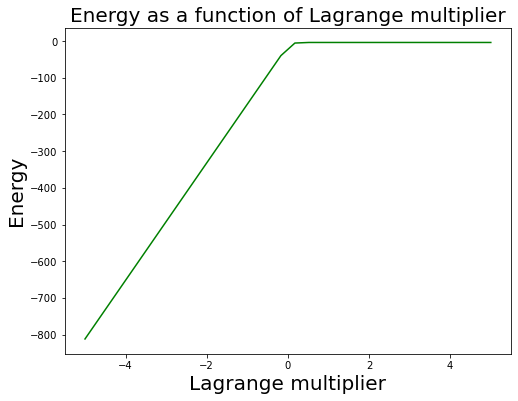

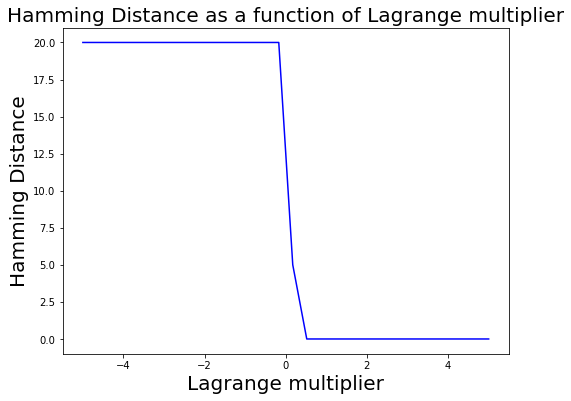

In [425]:
import matplotlib.pyplot as plt

#Energy plot
plt.figure(num=1,figsize=(8,6))
plt.plot(lagrange,energy_step,color='g')
plt.xlabel('Lagrange multiplier',fontsize=20)
plt.ylabel('Energy',fontsize=20)
plt.title('Energy as a function of Lagrange multiplier',fontsize=20)

#Hamming Distance plot
plt.figure(num=2,figsize=(8,6))
plt.plot(lagrange,hamming_distance,color='b')
plt.xlabel('Lagrange multiplier',fontsize=20)
plt.ylabel('Hamming Distance',fontsize=20)
plt.title('Hamming Distance as a function of Lagrange multiplier',fontsize=20)


In [238]:
# We check for energy 
print(sample,energy)

{'x00': 0, 'x01': 0, 'x02': 0, 'x03': 0, 'x04': 0, 'x05': 0, 'x06': 0, 'x07': 0, 'x08': 0, 'x09': 1, 'x10': 1, 'x11': 0, 'x12': 0, 'x13': 0, 'x14': 0, 'x15': 0, 'x16': 0, 'x17': 0, 'x18': 0, 'x19': 0, 'x20': 0, 'x21': 0, 'x22': 1, 'x23': 0, 'x24': 0, 'x25': 0, 'x26': 0, 'x27': 0, 'x28': 0, 'x29': 0, 'x30': 0, 'x31': 0, 'x32': 0, 'x33': 0, 'x34': 0, 'x35': 0, 'x36': 0, 'x37': 1, 'x38': 0, 'x39': 0, 'x40': 0, 'x41': 0, 'x42': 0, 'x43': 1, 'x44': 0, 'x45': 0, 'x46': 0, 'x47': 0, 'x48': 0, 'x49': 0, 'x50': 0, 'x51': 0, 'x52': 0, 'x53': 0, 'x54': 0, 'x55': 1, 'x56': 0, 'x57': 0, 'x58': 0, 'x59': 0, 'x60': 0, 'x61': 1, 'x62': 0, 'x63': 0, 'x64': 0, 'x65': 0, 'x66': 0, 'x67': 0, 'x68': 0, 'x69': 0, 'x70': 0, 'x71': 0, 'x72': 0, 'x73': 0, 'x74': 1, 'x75': 0, 'x76': 0, 'x77': 0, 'x78': 0, 'x79': 0, 'x80': 0, 'x81': 0, 'x82': 0, 'x83': 0, 'x84': 0, 'x85': 0, 'x86': 1, 'x87': 0, 'x88': 0, 'x89': 0, 'x90': 0, 'x91': 0, 'x92': 0, 'x93': 0, 'x94': 0, 'x95': 0, 'x96': 0, 'x97': 0, 'x98': 1, 'x99': 0}

In [239]:
#Sanity check for the constraints
efficiency=0

for agent in range(num_agents):
    count=0
    for task in range(num_tasks):
        count+=sample['x'+str(agent)+str(task)]
        if(sample['x'+str(agent)+str(task)]==1):
            efficiency+=W[agent,task]
    if(count!=1):
        print('Incorrect solution')
        break

In [240]:
print(efficiency)

8.595136072841644


# UNBALANCED ASSIGNMENT PROBLEM AS DQM

In an unbalanced problem formulation, the size of the num_agents A is not equal to num_tasks T. Here, we take the case where num_agents is less than num_tasks. In addition, each task has to be completed a certain number of times. Thus, we have a task_array '$t$' of length (num_tasks) which has the values as to how many times that specific task has to be completed. This is an equality constraint. Each agent can either do a certain number of tasks modelled as the discrete variables in DQM. There is also an upper bound $U$ on the number of tasks that each agent can do. Right now, we have not given the preference to the agents. We set $U$ which we will discuss after introducing the cost Hamiltonian for this problem. We again have to maximise the efficiency. 

$$H_c=_{min}\left(-\sum\limits_{i=1}^{A}\sum\limits_{j=1}^{T}w_{i,j}x_{i,j}+\gamma\left(\sum\limits_{j=1}^{T}\left(\sum\limits_{i=1}^{A}x_{i,j}-t_j\right)^2+\sum\limits_{i=1}^{A}\left(\sum\limits_{n=1}^{U}ny_{i,n}-\sum\limits_{j=1}^{T}x_{i,j}\right)^2\right)\right)$$

where $x_{i,j}$ are discrete variables and can take values $(0,1,...U)$ where $U=sum(t)/A$ representing average number of tasks per agent. $y_{i,n}$ are auxiliary variables which take the value 1 if the total number of tasks per agent is n and 0 otherwise. The third term penalizes if an agent crosses the upper bound U on the number of tasks that one has to do. $x_{i,j}$ represents how many number of tasks $i^{th}$ agent will finish for each task( as given by the t array). This is where DQM comes into play. 

In [335]:
from dimod import DiscreteQuadraticModel

In [408]:
num_agents=3
num_tasks=5
task_array=[2,2,3,1,3]
lagrange1=20
discrete_max_limit=int(np.floor(np.sum(task_array)/num_agents))
num_array=np.array(range(discrete_max_limit))
W=np.random.rand(num_agents,num_tasks)

In [409]:
dqm=DiscreteQuadraticModel()
#Declare variables
for agent in range(num_agents):
    for task in range(num_tasks):
        dqm.add_variable(discrete_max_limit,label='x'+str(agent)+str(task))
        
#Hamiltonian for xij-xij terms      
for task in range(num_tasks):
    for agent in range(num_agents):
        dqm.set_linear('x'+str(agent)+str(task),2*lagrange1*num_array**2+
                       (-2*lagrange1*task_array[task]-W[agent,task])*num_array)
        
#Hamiltonian for xij-xkj terms         
for task in range(num_tasks):
    for agent1 in range(num_agents):
        for agent2 in range(agent1+1,num_agents):
            dict_quad={}
            for number1 in num_array:
                for number2 in num_array:
                    dict_quad[(number1,number2)]=2*lagrange1*number1*number2 
            dqm.set_quadratic('x'+str(agent1)+str(task),'x'+str(agent2)+str(task),dict_quad) 
            
#Hamiltonian for xij-xik terms 
            
for agent in range(num_agents):
    for task1 in range(num_tasks):
        for task2 in range(task1+1,num_tasks):
            dict_quad={}
            for number1 in num_array:
                for number2 in num_array:
                    dict_quad[(number1,number2)]=2*lagrange1*number1*number2
              
            dqm.set_quadratic('x'+str(agent)+str(task1),'x'+str(agent)+str(task2),dict_quad) 


# Add the number of auxiliary variables 
num_spins=discrete_max_limit      
for agent in range(num_agents):
    for spin in range(1,num_spins):
        dqm.add_variable(2,label='y'+str(agent)+str(spin))
        
#Hamiltonian for yin-yin terms         
for agent in range(num_agents):
    for spin in range(1,num_spins):
        dqm.set_linear('y'+str(agent)+str(spin),lagrange1*np.array([0,1])*spin**2)
        
#Hamiltonian for yin-yio terms        
for agent in range(num_agents):
    for spin1 in range(1,num_spins):
        for spin2 in range(spin1+1,num_spins):
            dqm.set_quadratic('y' + str(agent)+str(spin1), 'y' + str(agent)+str(spin2), {(1,1):2*lagrange1*spin1*spin2})

#Hamiltonian for yin-xij terms 
for agent in range(num_agents):
    for task in range(num_tasks):
        for spin in range(1,num_spins):
            dict_quad={}
            for number in num_array:
                dict_quad[(number,1)]=-2*lagrange1*number*spin
            dqm.set_quadratic('x' + str(agent)+str(task),'y' + str(agent)+str(spin),dict_quad)

In [410]:
#Find the solution
sampler = LeapHybridDQMSampler(token='DEV-3fc4e66bf879e3fb40a1d09e8be0a7654e806d3c')

# Solve the problem using the DQM solver
sampleset = sampler.sample_dqm(dqm, label='Example - Unbalanced Scheduling Assignment')

# get the first solution, and print it
sample = sampleset.first.sample
energy = sampleset.first.energy

In [411]:
print(sample)

{'x00': 0, 'x01': 0, 'x02': 1, 'x03': 0, 'x04': 2, 'x10': 0, 'x11': 0, 'x12': 2, 'x13': 1, 'x14': 1, 'x20': 2, 'x21': 2, 'x22': 0, 'x23': 0, 'x24': 0, 'y01': 1, 'y02': 1, 'y11': 1, 'y12': 1, 'y21': 1, 'y22': 1}


In [412]:
print(W)

[[0.60687523 0.54182086 0.37430869 0.37734984 0.61144115]
 [0.12097777 0.60724208 0.90335444 0.96749492 0.31037134]
 [0.7973549  0.78600107 0.03272764 0.33981593 0.20168724]]


In [413]:
print(task_array)

[2, 2, 3, 1, 3]


In [414]:
print(discrete_max_limit)

3


In [415]:
#Sanity Checks for constraint 1: For each task, the totality requirement is satisfied
for task in range(num_tasks):
    sum=0
    for agent in range(num_agents):
        sum+=sample['x'+str(agent)+str(task)]
    if(sum!=task_array[task]):
        print('Incorrect solution')
        break

In [416]:
#Sanity Checks for constraint 2: For each agent, the upper limit of the number of total discrete variables i.e.
#(max tasks limit) is not crossed.  
for agent in range(num_agents):
    sum=0
    for task in range(num_tasks):
        sum+=sample['x'+str(agent)+str(task)]
    if(sum>(discrete_max_limit+1)):
        print('Incorrect solution')
        break

In [417]:
#Calculate efficiency
efficiency=0
for agent in range(num_agents):
    for task in range(num_tasks):
        efficiency+=W[agent,task]*sample['x'+str(agent)+str(task)]

In [419]:
print(efficiency)

7.848478053586254
